In [1]:
import os
import cv2
import time
import json
import colorsys
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from functools import partial
from dataclasses import dataclass, field
from sklearn.cluster import KMeans, DBSCAN
from typing import Callable, Optional, TypedDict

In [2]:
# Global variables

# Path to directories
IMGS_DIR = Path(".", "images")
OUTPUT_DIR = Path(".", "output")
LINE_WIDTH = 8

In [3]:
# Read image paths
imgs_paths: list[Path] = []
for file in Path(IMGS_DIR).iterdir():
    if file.is_file() and file.suffix.lower() in {".jpg", ".png", ".jpeg"}:
        imgs_paths.append(file)

In [ ]:
def get_distinct_colors(amount: int) -> list[tuple[int, int, int]]:
    """
    Generates a list of unique and distinct colors.
    Each color is represented as an RGB tuple.
    """
    colors = []
    for i in range(amount):
        # Evenly distribute hues in the HSV color space
        hue = i / amount
        saturation = 1.0  # Full saturation for vibrant colors
        value = 1.0  # Full brightness
        # Convert HSV to RGB and scale to 0-255
        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        rgb_scaled = tuple(int(c * 255) for c in rgb)
        colors.append(rgb_scaled)

    return colors


def plot_and_save_images(
    left: np.ndarray, right: np.ndarray, out_dir: Path, name: str
) -> None:
    """
    Plots and saves the images side by side.
    """
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(cv2.cvtColor(left, cv2.COLOR_BGR2RGB))
    ax[0].axis("off")
    ax[1].imshow(cv2.cvtColor(right, cv2.COLOR_BGR2RGB))
    ax[1].axis("off")
    plt.tight_layout()
    plt.show()
    plt.savefig(out_dir / f"{name}.png", bbox_inches="tight")
    plt.close()


def kmeans_clustering(
    image: np.ndarray, n_clusters: int
) -> tuple[np.ndarray, np.ndarray]:
    """
    Applies KMeans clustering to the image and returns the labels and cluster centers.

    Args:
        image (np.ndarray): The input image as a NumPy array.
        n_clusters (int): The number of clusters to form.

    Returns:
        tuple[np.ndarray, np.ndarray]: A tuple containing the labels for each pixel and number of clusters.
    """
    shape = image.shape
    pixels = image.reshape(-1, 3)  # Reshape to a 2D array of pixels
    kmeans = KMeans(
        n_clusters=n_clusters, random_state=42
    )  # Adjust n_clusters as needed
    kmeans.fit(pixels)
    labels = kmeans.labels_  # Get the cluster labels for each pixel
    unique_labels = np.unique(labels, axis=0)  # Get unique labels
    labels = labels.reshape(shape[:2])  # Reshape back to the original image shape
    # centers = kmeans.cluster_centers_  # Get the cluster centers (colors)
    return labels, unique_labels


def dbscan_clustering(
    image: np.ndarray,
    eps: float,
    min_samples: int,
    *,
    algorithm: str = "auto",
    quantization: Optional[int],
) -> tuple[np.ndarray, np.ndarray]:
    """
    Applies DBSCAN clustering to the image and returns the cluster labels.

    Required Args:
        image (np.ndarray): The input image as a NumPy array.
        eps (float): The maximum distance between two samples for them to be considered as in the same neighborhood.
        min_samples (int): The number of samples in a neighborhood for a point to be considered as a core point.

    Optional Args:
        algorithm (str): The algorithm to use for clustering. Options are 'auto', 'ball_tree', 'kd_tree', or 'brute'.
        quantization (int): The number of colors to quantize the image to. If None, no quantization is applied.

    Returns:
        tuple[np.ndarray, np.ndarray]: A tuple containing the labels for each pixel and number of clusters.
    """
    shape = image.shape
    pixels = image.reshape(-1, 3)  # Reshape to a 2D array of pixels

    # Apply quantization if specified
    if quantization is not None:
        # First normalize the pixel values to the range [0, 255]
        pixels = np.clip(pixels, 0, 255).astype(np.uint8)
        # Quantize the colors to reduce the number of unique colors
        quantized_pixels = np.floor_divide(pixels, quantization) * quantization

        # Get unique quantized colors and their indices
        unique_colors, inverse_indices = np.unique(
            quantized_pixels, axis=0, return_inverse=True
        )
        print(f"Quantized colors: {len(unique_colors)}")
        # print(f"Example unique colors: {unique_colors[:10]}")
        # colors_by_frequency = np.bincount(inverse_indices)
        # sorted_indices = np.argsort(colors_by_frequency)[::-1]
        # colors_with_frequency = []
        # for i in sorted_indices:
        #     color = unique_colors[i]
        #     frequency = colors_by_frequency[i]
        #     colors_with_frequency.append(
        #         (tuple([int(c) for c in color]), int(frequency))
        #     )
        # print(f"Most common colors: {colors_with_frequency[:10]}")

        # Run DBSCAN on the unique colors only
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, algorithm=algorithm)
        unique_labels = dbscan.fit_predict(unique_colors)

        # Map the unique labels back to all pixels using the inverse indices
        labels = unique_labels[inverse_indices]
    else:
        # Run DBSCAN directly on all pixels
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, algorithm=algorithm)
        labels = dbscan.fit_predict(pixels)

    # Reshape labels to match the 2D shape of the image
    unique_labels = np.unique(labels, axis=0)
    labels = labels.reshape(shape[:2])
    return labels, unique_labels


def color_distance(color1, color2):
    """Custom distance metric for colors that puts more emphasis on hue differences"""
    # Convert to HSV for better perceptual distance
    c1 = np.array(color1, dtype=np.float32) / 255.0
    c2 = np.array(color2, dtype=np.float32) / 255.0

    # Simple weighted RGB distance that emphasizes differences in proportions
    diff = np.abs(c1 - c2)
    return np.sum(diff) * 255  # Scale back to 0-255 range


def dbscan_clustering_custom(
    image: np.ndarray,
    eps: float,
    min_samples: int,
    *,
    quantization: Optional[int] = None,
) -> tuple[np.ndarray, np.ndarray]:
    """DBSCAN clustering with custom distance metric"""
    print(f"Running DBSCAN clustering with parameters eps={eps}, min_samples={min_samples}, quantization={quantization}")
    shape = image.shape
    pixels = image.reshape(-1, 3)

    # Apply quantization if specified
    if quantization is not None:
        pixels = np.clip(pixels, 0, 255).astype(np.uint8)
        quantized_pixels = np.floor_divide(pixels, quantization) * quantization

        # Get unique quantized colors and their indices
        unique_colors, inverse_indices = np.unique(
            quantized_pixels, axis=0, return_inverse=True
        )
        print(f"Quantized colors: {len(unique_colors)}")

        # Compute distance matrix
        n_colors = len(unique_colors)
        distance_matrix = np.zeros((n_colors, n_colors))
        for i in range(n_colors):
            for j in range(i + 1, n_colors):
                dist = color_distance(unique_colors[i], unique_colors[j])
                distance_matrix[i, j] = dist
                distance_matrix[j, i] = dist

        # Run DBSCAN with precomputed distances
        dbscan = DBSCAN(
            eps=eps, min_samples=min_samples, metric="precomputed", algorithm="brute"
        )
        unique_labels = dbscan.fit_predict(distance_matrix)

        # Map the unique labels back to all pixels using the inverse indices
        labels = unique_labels[inverse_indices]
    else:
        pixels_uint8 = np.clip(pixels, 0, 255).astype(np.uint8)
        pixels_reshaped = pixels_uint8.reshape(1, -1, 3)

        # Define custom metric function for sklearn
        def custom_metric(X, Y):
            return color_distance(X, Y)

        # Run DBSCAN with custom metric
        dbscan = DBSCAN(
            eps=eps, min_samples=min_samples, metric=custom_metric, algorithm="brute"
        )
        labels = dbscan.fit_predict(pixels_reshaped)

    # Reshape labels to match the 2D shape of the image
    unique_labels = np.unique(labels, axis=0)
    labels = labels.reshape(shape[:2])
    return labels, unique_labels


def dbscan_clustering_custom_distances(
    image: np.ndarray,
    eps: float,
    min_samples: int,
    *,
    quantization: Optional[int] = None,
    spatial_weight: float = 0.1,  # Weight for spatial information
) -> tuple[np.ndarray, np.ndarray]:
    """DBSCAN clustering with custom distance metric that includes spatial information"""
    shape = image.shape
    pixels = image.reshape(-1, 3)

    # Create spatial coordinates
    h, w = shape[:2]
    y_coords, x_coords = np.mgrid[0:h, 0:w]

    # Normalize spatial coordinates to have similar scale as color values
    x_normalized = x_coords.flatten() / w * 255
    y_normalized = y_coords.flatten() / h * 255

    # Apply quantization if specified
    if quantization is not None:
        pixels = np.clip(pixels, 0, 255).astype(np.uint8)
        quantized_pixels = np.floor_divide(pixels, quantization) * quantization

        # Create a feature vector that includes both color and spatial information
        # We'll create a unique identifier for each combination of color and position
        feature_vectors = np.column_stack(
            [
                quantized_pixels,
                np.round(x_normalized / quantization) * quantization,
                np.round(y_normalized / quantization) * quantization,
            ]
        )

        # Get unique feature vectors and their indices
        unique_features, inverse_indices = np.unique(
            feature_vectors, axis=0, return_inverse=True
        )
        print(f"Unique feature vectors: {len(unique_features)}")

        # Extract color and spatial components
        unique_colors = unique_features[:, :3]
        unique_positions = unique_features[:, 3:5]

        # Compute distance matrix
        n_features = len(unique_features)
        distance_matrix = np.zeros((n_features, n_features))

        for i in range(n_features):
            for j in range(i + 1, n_features):
                # Color distance
                color_dist = color_distance(unique_colors[i], unique_colors[j])

                # Spatial distance (Euclidean)
                spatial_dist = np.sqrt(
                    np.sum((unique_positions[i] - unique_positions[j]) ** 2)
                )

                # Combined distance with weighting
                combined_dist = color_dist + spatial_weight * spatial_dist

                distance_matrix[i, j] = combined_dist
                distance_matrix[j, i] = combined_dist

        # Run DBSCAN with precomputed distances
        dbscan = DBSCAN(
            eps=eps, min_samples=min_samples, metric="precomputed", algorithm="brute"
        )
        unique_labels = dbscan.fit_predict(distance_matrix)

        # Map the unique labels back to all pixels using the inverse indices
        labels = unique_labels[inverse_indices]
    else:
        # For non-quantized version, create feature vectors with color and spatial information
        pixels_uint8 = np.clip(pixels, 0, 255).astype(np.uint8)

        # Define custom metric function that considers both color and spatial information
        def custom_metric(X, Y):
            # Color distance
            color_X, color_Y = X[:3], Y[:3]
            color_dist = color_distance(color_X, color_Y)

            # Spatial distance
            pos_X, pos_Y = X[3:5], Y[3:5]
            spatial_dist = np.sqrt(np.sum((pos_X - pos_Y) ** 2))

            # Combined distance
            return color_dist + spatial_weight * spatial_dist

        # Create feature vectors combining color and spatial information
        features = np.column_stack(
            [pixels_uint8, x_normalized.reshape(-1, 1), y_normalized.reshape(-1, 1)]
        )

        # Run DBSCAN with custom metric
        dbscan = DBSCAN(
            eps=eps, min_samples=min_samples, metric=custom_metric, algorithm="brute"
        )
        labels = dbscan.fit_predict(features)

    # Reshape labels to match the 2D shape of the image
    unique_labels = np.unique(labels)
    labels = labels.reshape(shape[:2])
    return labels, unique_labels


class CoverageData(TypedDict):
    global_coverage: dict[str, float]
    cell_coverage: dict[str, dict[str, float]]


@dataclass
class ClusterResult:
    labels: np.ndarray
    label_ids: np.ndarray
    coverage: CoverageData = field(default_factory=dict)


def analyze_image(
    in_path: Path,
    out_dir: Path,
    *,
    scale_factor: float = 1.0,
    grid_shape: tuple[int, int],
    clusterer: Callable[[np.ndarray], tuple[np.ndarray, int]],
) -> ClusterResult:
    """
    Takes a path to an image and returns a dictionary with the estimated coverage percent of each cell in the grid.
    """

    # Load the input image
    image = cv2.imread(str(in_path), cv2.IMREAD_COLOR)
    if image is None:
        print("Failed to load image:", in_path)
        return
    print("Loaded image:", in_path)

    # Create the output directory if it doesn't exist
    os.makedirs(out_dir, exist_ok=True)

    # Scale down the image
    width = int(image.shape[1] * scale_factor)
    height = int(image.shape[0] * scale_factor)
    processed_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)

    # Cluster the pixel colors using the provided clustering method
    print("Clustering image...")
    start_time = time.time()
    labels, label_ids = clusterer(processed_image)
    n_clusters = len(label_ids)
    cluster_colors = get_distinct_colors(n_clusters)
    end_time = time.time()
    print(
        f"Clustering took {end_time - start_time:.2f} seconds. Found {n_clusters} clusters."
    )

    # Create a mask for each cluster
    masks = np.zeros_like(processed_image, dtype=np.uint8)
    for i in label_ids:
        mask = (labels == i).reshape(processed_image.shape[:2])
        masks[mask] = cluster_colors[i]

    # Compute the global and local coverage properties

    # Calculate the coverage percentage for each cluster
    global_coverage: dict[int, float] = {}
    total_pixels = processed_image.shape[0] * processed_image.shape[1]
    for i in label_ids:
        global_coverage[str(i)] = float(np.sum(labels == i) / total_pixels * 100)

    # Calculate the coverage percentage for each grid cell
    grid_height, grid_width = grid_shape
    cell_height = processed_image.shape[0] // grid_height
    cell_width = processed_image.shape[1] // grid_width
    cell_coverage: dict[str, dict[int, float]] = {}

    # Update the cell coverage calculation
    for i in range(grid_height):
        for j in range(grid_width):
            cell_mask = np.zeros(
                (processed_image.shape[0], processed_image.shape[1]), dtype=np.uint8
            )
            cell_mask[
                i * cell_height : (i + 1) * cell_height,
                j * cell_width : (j + 1) * cell_width,
            ] = 1
            cell_coverage[f"({i}, {j})"] = {}
            for k in label_ids:
                cell_coverage[f"({i}, {j})"][str(k)] = float(
                    np.sum((labels == k) & (cell_mask == 1)) / np.sum(cell_mask) * 100
                )

    # Paint all pixels with their cluster color
    for i in label_ids:
        mask = (labels == i).reshape(processed_image.shape[:2])
        processed_image[mask] = cluster_colors[i]

    # Draw grid lines
    for i in range(1, grid_height):
        cv2.line(
            processed_image,
            (0, i * cell_height),
            (processed_image.shape[1], i * cell_height),
            (255, 255, 255),
            LINE_WIDTH,
        )
    for j in range(1, grid_width):
        cv2.line(
            processed_image,
            (j * cell_width, 0),
            (j * cell_width, processed_image.shape[0]),
            (255, 255, 255),
            LINE_WIDTH,
        )

    # Display the image
    plot_and_save_images(image, processed_image, out_dir, in_path.stem)
    coverage: CoverageData = {
        "global_coverage": global_coverage,
        "cell_coverage": cell_coverage,
    }
    out_json_path = out_dir / (in_path.stem + "_coverage.json")
    with open(out_json_path, "w") as f:
        json.dump(coverage, f, indent=4)

    return ClusterResult(
        labels=labels,
        label_ids=label_ids,
        coverage=coverage,
    )

# Analyze single image
test_img_path = Path(IMGS_DIR, "Al_6d_0.jpg")

KMeans clustering:
Loaded image: images\Al_6d_0.jpg
Clustering image...
Clustering took 9.56 seconds. Found 2 clusters.


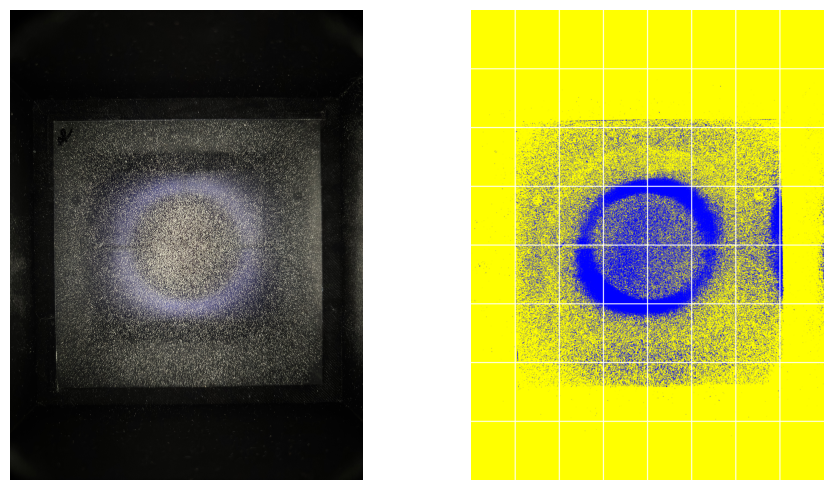

ClusterResult(labels=array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], shape=(4032, 3024), dtype=int32), label_ids=array([0, 1], dtype=int32), coverage={'global_coverage': {'0': 16.02925603111615, '1': 83.97074396888385}, 'cell_coverage': {'(0, 0)': {'0': 0.0, '1': 100.0}, '(0, 1)': {'0': 0.0, '1': 100.0}, '(0, 2)': {'0': 0.0, '1': 100.0}, '(0, 3)': {'0': 0.0, '1': 100.0}, '(0, 4)': {'0': 0.0, '1': 100.0}, '(0, 5)': {'0': 0.0, '1': 100.0}, '(0, 6)': {'0': 0.0, '1': 100.0}, '(0, 7)': {'0': 0.0, '1': 100.0}, '(1, 0)': {'0': 0.01889644746787604, '1': 99.98110355253212}, '(1, 1)': {'0': 0.5312001343747376, '1': 99.46879986562526}, '(1, 2)': {'0': 1.964705635340556, '1': 98.03529436465944}, '(1, 3)': {'0': 2.4623120853279583, '1': 97.53768791467205}, '(1, 4)': {'0': 3.0024355421180817, '1': 96.99756445788191}, '(1, 5)': {'0': 2.4134962627

In [26]:
print("KMeans clustering:")
prepared_kmeans = partial(kmeans_clustering, n_clusters=2)
analyze_image(test_img_path, OUTPUT_DIR, scale_factor=0.5, grid_shape=(8,8), clusterer=prepared_kmeans)

DBSCAN clustering:
Loaded image: images\Al_6d_0.jpg
Clustering image...
Quantized colors: 927
Clustering took 3.15 seconds. Found 3 clusters.


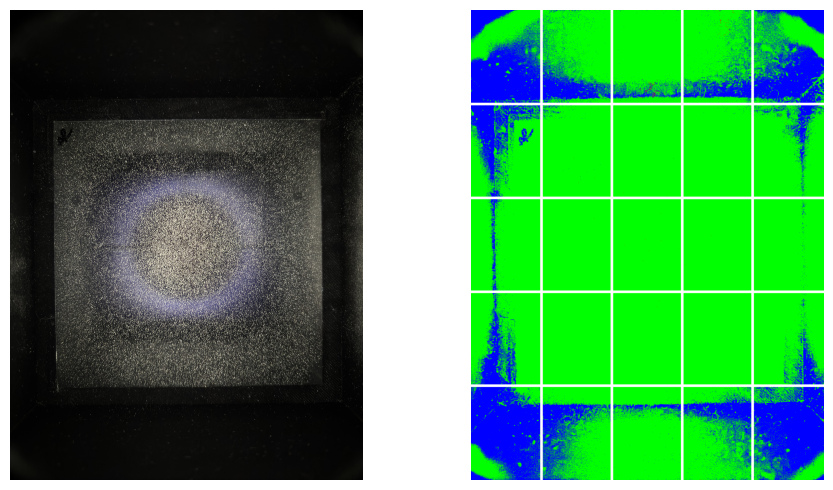

ClusterResult(labels=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(1612, 1209)), label_ids=array([-1,  0,  1]), coverage={'global_coverage': {'-1': 0.032838902605972164, '0': 18.51077629113329, '1': 81.45638480626074}, 'cell_coverage': {'(0, 0)': {'-1': 0.007731759490734775, '0': 64.53957372232675, '1': 35.45269451818252}, '(0, 1)': {'-1': 0.024483905053993456, '0': 24.227468364217415, '1': 75.74804773072859}, '(0, 2)': {'-1': 0.2783433416664519, '0': 6.392876472255869, '1': 93.32878018607768}, '(0, 3)': {'-1': 0.15205793665111722, '0': 18.48148243601969, '1': 81.36645962732919}, '(0, 4)': {'-1': 0.04767918352619778, '0': 55.89675523826706, '1': 44.055565578206746}, '(1, 0)': {'-1': 0.024483905053993456, '0': 32.679570114172314, '1': 67.29594598077368}, '(1, 1)': {'-1': 0.01417489239968042, '0': 0.85822530347156, '1': 99.1

In [29]:
print("DBSCAN clustering:")
prepared_dbscan = partial(dbscan_clustering, eps=8, min_samples=5, algorithm='kd_tree', quantization=8)
analyze_image(test_img_path, OUTPUT_DIR, scale_factor=0.2, grid_shape=(5,5), clusterer=prepared_dbscan)

DBSCAN clustering (custom):
Loaded image: images\Al_6d_0.jpg
Clustering image...
Quantized colors: 927
Clustering took 6.49 seconds. Found 18 clusters.


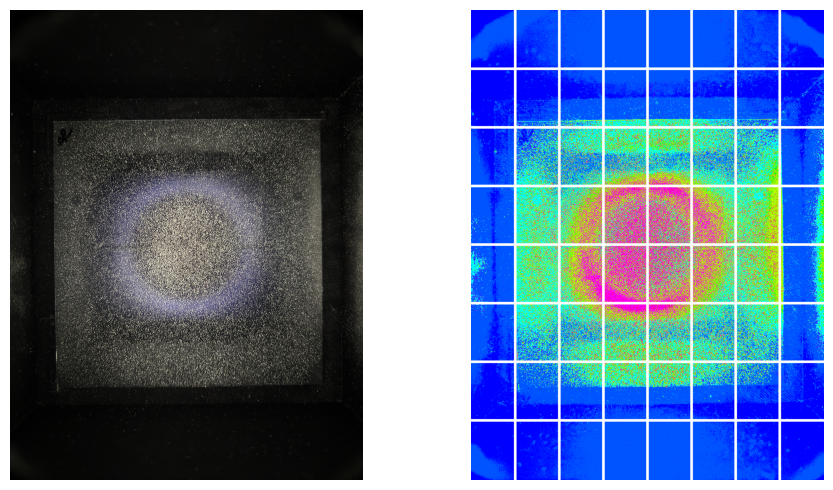

ClusterResult(labels=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(1612, 1209)), label_ids=array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16]), coverage={'global_coverage': {'-1': 2.1596709541958883, '0': 18.51077629113329, '1': 39.88371949830366, '2': 0.019292855281008648, '3': 14.770014798030488, '4': 0.2616850051413407, '5': 0.33080063296984774, '6': 1.675810248611017, '7': 0.8223066455676717, '8': 13.156187978088244, '9': 0.21801952683246206, '10': 0.03140220061696088, '11': 0.25132022650633074, '12': 0.9379098448977582, '13': 0.025552771090272087, '14': 0.659292280600213, '15': 6.1795118086641345, '16': 0.10672643346940955}, 'cell_coverage': {'(0, 0)': {'-1': 0.009884353069091627, '0': 50.107080491581826, '1': 49.883035155349084, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.0, '6': 0.0, '7':

In [30]:
print("DBSCAN clustering (custom):")
prepared_dbscan_custom = partial(
    dbscan_clustering_custom, eps=8, min_samples=5, quantization=8
)
analyze_image(
    test_img_path,
    OUTPUT_DIR,
    scale_factor=0.2,
    grid_shape=(8, 8),
    clusterer=prepared_dbscan_custom,
)

In [ ]:
# Takes too long to run
# print("DBSCAN clustering (custom, distance):")
# prepared_dbscan_custom_dist = partial(
#     dbscan_clustering_custom_distances, eps=8, min_samples=5, quantization=64
# )
# analyze_image(
#     test_img_path,
#     OUTPUT_DIR,
#     scale_factor=0.2,
#     grid_shape=(5, 5),
#     clusterer=prepared_dbscan_custom_dist,
# )

In [ ]:
# Analyze all images using different cluster counts
for path in imgs_paths:
    analyze_image(path, OUTPUT_DIR / "clusters-2", 2)
    analyze_image(path, OUTPUT_DIR / "clusters-3", 3)